# CRR Perf Explore

Creates some CRR tables and runs various insert/update/delete operations against them.
Each set of operations is timed.

In [213]:
%xmode Verbose

Exception reporting mode: Verbose


In [214]:
import sqlite3
import os
import time
import random
import string
import matplotlib.pyplot as plt

def random_str():
  ''.join(random.choices(string.ascii_lowercase, k=5))

c = sqlite3.connect(":memory:")
c.enable_load_extension(True)
c.execute("select load_extension('./dist/cfsqlite')")

trials = 30
batch_size = 1000

# Create CRR tables

In [215]:
c.execute("select cfsql('CREATE TABLE \"user\" (id primary key, name)')")
c.execute("select cfsql('CREATE TABLE deck (id primary key, owner_id, title)')")
c.execute("select cfsql('CREATE TABLE slide (id primary key, deck_id, \"order\")')")
c.execute("select cfsql('CREATE TABLE component (id primary key, type, slide_id, content)')")

# Create Vanilla Tables

In [216]:
c.execute("CREATE TABLE vuser (id primary key, name)")
c.execute("CREATE TABLE vdeck (id primary key, owner_id, title)")
c.execute("CREATE TABLE vslide (id primary key, deck_id, \"order\")")
c.execute("CREATE TABLE vcomponent (id primary key, type, slide_id, content)")

# Insert / Update / Delete Defs

In [217]:
def truncate(pfx):
  c.execute("DELETE FROM {pfx}user".format(pfx=pfx))
  c.execute("DELETE FROM {pfx}deck".format(pfx=pfx))
  c.execute("DELETE FROM {pfx}slide".format(pfx=pfx))
  c.execute("DELETE FROM {pfx}component".format(pfx=pfx))

def insert(pfx, count, offset):
  for i in range(count):
    c.execute("INSERT INTO {pfx}user VALUES (?, ?)".format(pfx = pfx), (i + offset, random_str()))
    c.execute("INSERT INTO {pfx}deck VALUES (?, ?, ?)".format(pfx = pfx), (i + offset, i + offset, random_str()))
    c.execute("INSERT INTO {pfx}slide VALUES (?, ?, ?)".format(pfx = pfx), (i + offset, i + offset, i))
    c.execute("INSERT INTO {pfx}component VALUES (?, ?, ?, ?)".format(pfx = pfx), (i + offset, "text", i + offset, random_str()))

def update(pfx, count, offset):
  for i in range(count):
    c.execute("UPDATE {pfx}user SET name = ? WHERE id = ?".format(pfx = pfx), (random_str(), i + offset))
    c.execute("UPDATE {pfx}deck SET title = ? WHERE id = ?".format(pfx = pfx), (random_str(), i + offset))
    c.execute("UPDATE {pfx}slide SET \"order\" = ? WHERE id = ?".format(pfx = pfx), (i + 1, i + offset))
    c.execute("UPDATE {pfx}component SET content = ? WHERE id = ?".format(pfx = pfx), (random_str(), i + offset))

def read(pfx, count, offset):
  for i in range(count):
    c.execute("SELECT * FROM {pfx}user WHERE id = {id}".format(pfx = pfx, id = i + offset))
    c.execute("SELECT * FROM {pfx}deck WHERE id = {id}".format(pfx = pfx, id = i + offset))
    c.execute("SELECT * FROM {pfx}slide WHERE id = {id}".format(pfx = pfx, id = i + offset))
    c.execute("SELECT * FROM {pfx}component WHERE id = {id}".format(pfx = pfx, id = i + offset))

def time_x(type, fn):
  timings = []

  # do N trials
  for i in range(trials):
    start = time.perf_counter_ns()
    fn(type, batch_size, batch_size * i)
    end = time.perf_counter_ns()
    timings.append((end-start)/1000000)
  
  return timings

def plot_timings(crr, vanilla, title):
  plt.plot(crr, color='blue', marker='o',mfc='navy' )
  plt.plot(vanilla, color='red', marker='x',mfc='pink' )
  plt.xticks(range(0,len(crr)+1, 1))

  plt.ylabel('time')
  plt.xlabel('trial')
  plt.title(title)
  plt.show()

def plot_xincrease(crr, vanilla, title):
  multiple = [c / v for c,v in zip(crr, vanilla)]
  plt.plot(multiple, color='brown', marker='o',mfc='red' )
  plt.xticks(range(0,len(crr)+1, 1))

  plt.ylabel('x')
  plt.xlabel('trial')
  plt.title(title)
  plt.show()


# Insert

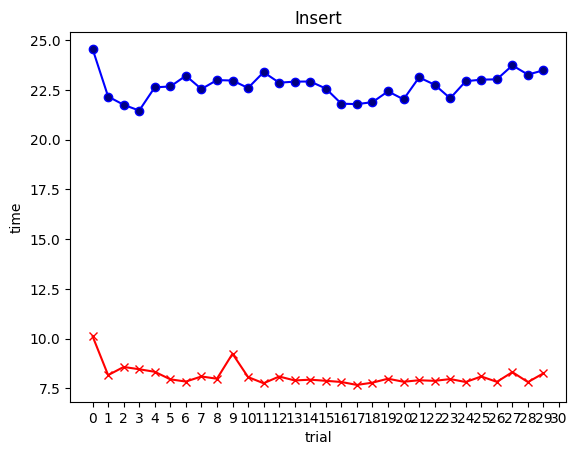

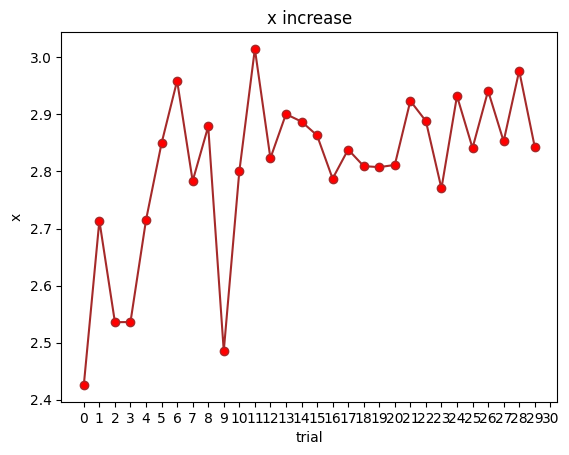

In [218]:
perf_vanilla_insert = time_x("v", insert)
perf_crr_insert = time_x("", insert)

plot_timings(perf_crr_insert, perf_vanilla_insert, "Insert")
plot_xincrease(perf_crr_insert, perf_vanilla_insert, "x increase")

# Update

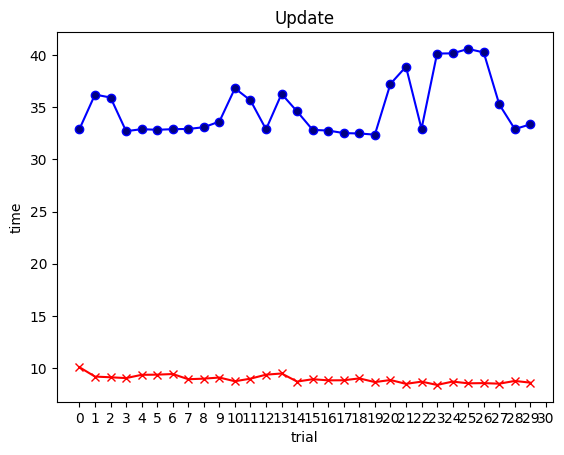

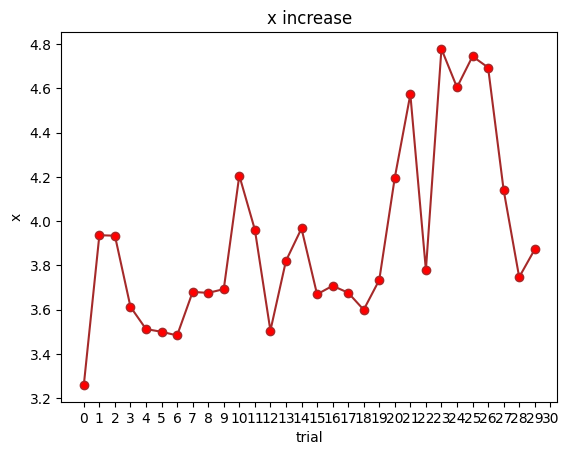

In [219]:
# TODO: just replace the update trigger with the insert trigger? Insert is an  upsert for CRRs and insert seems to perform better than
# update.
perf_vanilla_update = time_x("v", update)
perf_crr_update = time_x("", update)

plot_timings(perf_crr_update, perf_vanilla_update, "Update")
plot_xincrease(perf_crr_update, perf_vanilla_update, "x increase")

# Read

In [220]:
perf_vanilla_read = time_x("v", read)
perf_crr_read = time_x("", read)

plot_timings(perf_crr_read, perf_vanilla_read, "Read")
plot_xincrease(perf_crr_read, perf_vanilla_read, "x increase")

ValueError: parameters are of unsupported type

# Insert data that already exists

# Delete